In [30]:
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
# Load the data
genotypes = pd.read_csv('Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [33]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [34]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [35]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [39]:
# Define SVM for feature selection
# Adjusting SVM parameters with an extended range for C and including an RBF kernel
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 1000],
    'kernel': ['linear']
}

svm = SVR()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END .............................C=0.001, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, ke

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 1000],
                         'kernel': ['linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [40]:
# Feature selection
model = SelectFromModel(grid_search.best_estimator_, prefit=True)  # Adjusting the threshold
X_train_selected = pd.DataFrame(model.transform(X_train_scaled), columns=X_train_scaled.columns[model.get_support()])
X_test_selected = pd.DataFrame(model.transform(X_test_scaled), columns=X_test_scaled.columns[model.get_support()])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [47]:
# Export selected features
selected_features = X_train_selected.columns
pd.Series(selected_features).to_csv('selected_features_svm.csv', index=False)

In [42]:
# Regression
regressor = LinearRegression()
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)

In [43]:
print(y_pred)

[-2.97272264  2.25596972 -1.55555987  0.79570141 -1.04520148 -1.44596264
  0.42001072  0.80636431 -0.42897872  0.52616103 -2.81040953 -1.08959076
 -2.67369327 -0.99291366 -1.37527796  0.90922035  0.81111544  0.72728003
 -0.71981347 -1.37937318 -0.35259227 -3.37683815 -1.18421373 -0.18093191
 -3.15896659  0.05172402 -5.32872068 -1.87690588  4.39584971 -1.38684334
 -0.34100587  3.03580715 -0.91716451  5.54084624  3.55582375 -0.10802929
  0.04733932 -0.5861689   0.41444743 -0.34925382 -3.6189022   3.0719193
  3.36198714 -3.39790306 -2.78966957 -1.54834167 -2.29817994  1.84658983
 -0.5837758   4.72919446 -1.03968193 -1.78490094 -1.74996947 -0.26678
 -0.37902997 -0.88583843  0.17881755 -0.08273963  1.95680122]


In [44]:
y_test.head()

ID
SYNAGAD_087   -4.823664
SYNAGAD_263    2.638036
SYNAGAD_048   -0.346644
SYNAGAD_180    5.352002
SYNAGAD_146   -0.346644
Name: FREAR, dtype: float64

In [45]:
# Metrics
# Extract the negative mean squared error and convert to positive
mean_cv_mse = -grid_search.best_score_
rmse_cv = np.sqrt(mean_cv_mse)
print(f'Cross-validated RMSE: {rmse_cv}')

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

Cross-validated RMSE: 2.3598838567161406
Test RMSE: 2.490095768654819
Test R²: 0.12425639410122746


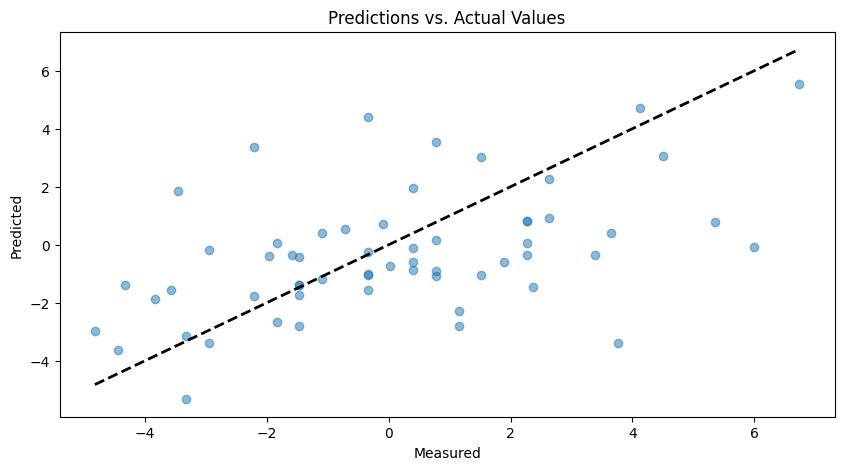

In [46]:
# Predictions plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()